# Assignment 8: Bagging and Boosting

Only use the already imported libraries and the Python standard libraries. For the evaluation you may also use scikit-learn (`sklearn`). Make sure that the datasets `titanic.csv` and `df_arabica_clean.csv` are in the same directory as the notebook.

List your team members (name and immatriculation number) and indicate whether you are a B.Sc. Data Science or other group in the following cell:

==> Participants Name
1. SampathKumar Dhulappa Itagi,370 ,M.S.c
* *matr. nr.* 
* *study program*
* *B.Sc./M.Sc.*

*of all assignment group participants here. (double klick here to edit)*

In [2]:
import abc

# You are allowed to use the numpy package and the DecisionTreeClassifier.
import matplotlib.pyplot as plt
import numpy as np
from sklearn.tree import DecisionTreeClassifier

import pandas as pd
import dateutil.parser
from sklearn.model_selection import train_test_split
from abc import ABC, abstractmethod
from typing import Protocol, List

In [3]:
class AnyPredictor(Protocol):
    
    def fit(self, X, y):
        ...
    
    def predict(self, X):
        ...

class BinaryClassificationDataset(Protocol):
    
    @property
    def feature_names(self) -> List[str]:
        ...
    
    @property
    def class_names(self) -> List[str]:
        ...
    
    def load(self):
        ...
    
    def summary(self):
        ...
    
    @property
    def X_train(self):
        ...
    
    @property
    def X_test(self):
        ...
    
    @property
    def y_train(self):
        ...
    
    @property
    def y_test(self):
        ...



class BaseBinaryClassificationDataset(BinaryClassificationDataset, abc.ABC):
    
    
    @property
    @abstractmethod
    def feature_names(self) -> List[str]:
        ...
    
    
    @property
    @abstractmethod
    def class_names(self) -> List[str]:
        ...
    
    @abstractmethod
    def load(self):
        ...
    
    def __init__(self):
        self._X_train = None
        self._X_test = None
        self._y_train = None
        self._y_test = None
    
    @property
    def X_train(self):
        return self._X_train
    
    @property
    def X_test(self):
        return self._X_test
    
    @property
    def y_train(self):
        return self._y_train
    
    @property
    def y_test(self):
        return self._y_test
    
    def summary(self):
        return f"A binary classification dataset with {self.X_train.shape[0]} training samples, {self.X_test.shape[0]} test samples, and { self.X_train.shape[-1] } features."
    
    __repr__ = summary
    __str__ = summary

In [4]:
class TitanicDataset(BaseBinaryClassificationDataset):
    
    @property
    def feature_names(self):
        return ['Sex', 'Age', 'Fare', 'Title_Master', 'Title_Miss', 
                'Title_Mr', 'Title_Mrs', 'Title_Rare', 'Pclass_1', 'Pclass_2',
                'Pclass_3', 'IsAlone', 'Embarked_C', 'Embarked_Q', 'Embarked_S']
    
    @property
    def class_names(self):
        return ['survived', 'dead']
    
    def load(self):
        df = pd.read_csv('titanic.csv')
    
        # The feature engineering mostly follows the notebook by Manav Segal: https://www.kaggle.com/startupsci/titanic-data-science-solutions
        # From the Name attribute we can extract titles, which gives insight about the social status/age/gender of the passenger.
        df['Title'] = df['Name'].str.extract(' ([a-zA-Z]+)\.', expand=False)
        df['Title'] = df['Title'].replace(['Lady', 'Countess', 'Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
        df['Title'] = df['Title'].replace(['Mlle', 'Ms'], 'Miss')
        df['Title'] = df['Title'].replace('Mme', 'Mrs')
        
        # We map the Title attribute to a one-hot encoding.
        df = df.join(pd.get_dummies(df['Title'], prefix='Title'))
    
        
        # We map the Sex attribute to a numeric representation.
        df['Sex'] = df['Sex'].map({'female': 1, 'male': 0}).astype(int)
    
        
        # We one-hot encode Pclass.
        df = df.join(pd.get_dummies(df['Pclass'], prefix='Pclass'))
    
        
        # Based on the number of sibling-spouses in SibSp and parents-childern in Parch, 
        # we can determine whether a passenger was on board alone.
        df['IsAlone'] = ((df['SibSp'] + df['Parch'] + 1) == 1).astype(int)
    
        
        # We remove all attributes that do not seem relevant to the prediction, or are already encoded in another attribute.
        df = df.drop(['PassengerId', 'Name', 'Title', 'Ticket', 'Cabin', 'Parch', 'SibSp'], axis=1)
    
        # For remaining features, we have to separate train and test, 
        # as we will impute missing data based on statistics in the training data.
        df_train, df_test = train_test_split(df, test_size=0.2, random_state=2024)
        # For Embarked, we set all missing values to the most frequent port and then one-hot encode the attribute.
        def impute_embarked():    
            freq_port = df_train['Embarked'].dropna().mode()[0]
            output = []
            for df in (df_train, df_test):
                df = df.join(pd.get_dummies(df['Embarked'].fillna(freq_port), prefix='Embarked'))
                df = df.drop('Embarked', axis=1)
                output.append(df)
            return output
    
        df_train, df_test = impute_embarked()
    
        # For Age, we set missing values to the median dependent on the pair of Sex and Pclass.
        guess_ages = np.zeros((2, 3))
        for df in (df_train, df_test):
            for i in range(2):
                for j in range(3):
                    guess_ages[i, j] = df[(df['Sex'] == i) & (df['Pclass'] == j+1)]['Age'].dropna().median()
            for i in range(2):
                for j in range(3):
                    df.loc[(df['Age'].isnull()) & (df['Sex'] == i) & (df['Pclass'] == j+1), 'Age'] = guess_ages[i, j]
            df['Age'] = df['Age'].astype(int)
    
        df_train = df_train.drop(['Pclass'], axis=1)
        df_test = df_test.drop(['Pclass'], axis=1)
    
        X_train = df_train.values[:, 1:]
        X_test = df_test.values[:, 1:]
        y_train = df_train.values[:, 0]
        y_test = df_test.values[:, 0]
        
        # convert the dtypes
        y_train = np.asarray(y_train, dtype='int')
        y_test = np.asarray(y_test, dtype='int')
        
        self._X_train = X_train
        self._X_test = X_test
        self._y_train = y_train
        self._y_test = y_test
        
        return X_train, X_test, y_train, y_test

In [5]:
class CoffeeDataset(BaseBinaryClassificationDataset):
    
    @property
    def feature_names(self):
        
        countries = [
        "Taiwan",
        "Guatemala",
        "Colombia",
        "Honduras",
        "Thailand",
        "Ethiopia",
        "Brazil",
        "Costa Rica",
        "Nicaragua",
        "El Salvador",
        ]
        
        feature_names = countries[:8] + [
            "Altitude",
            "Washed",
            "Pulped natural",
            "Natural",
            "Moisture Percentage",
            "Category One Defects",
            "Category Two Defects",
        ]
        return feature_names
    
    @property
    def class_names(self):
        return ["below average", "above average"]
    
    def load(self):
        
        # some of the preprocessing steps are taken from https://www.kaggle.com/code/tumpanjawat/coffee-eda-geo-cluster-regression#2-|-Exploratory-Data-Analysis-
        df = pd.read_csv("df_arabica_clean.csv")
    
        # create boolean values for defect classes
        df["Category Two Defects"] = df["Category Two Defects"] > 0
        df["Category One Defects"] = df["Category One Defects"] > 0
    
        # create one value for altitude
        df = df.join(
            df["Altitude"]
            .str.extract(r"^(?P<min_alt>\d*)\W*[-A~]\W*(?P<max_alt>\d*)$")
            .astype(float)
        )
        df.dtypes
        df["Altitude"] = (
            df[["min_alt", "max_alt"]]
            .mean(axis=1, skipna=True)
            .fillna(df["Altitude"])
            .astype(float)
        )
        df = df.dropna(subset=["Altitude"])
    
        # Extract the prior year from the "Harvest Year" column
        df["Harvest Year"] = df["Harvest Year"].str.split("/").str[0].str.strip()
    
        # Convert "Harvest Year" and "Expiration" columns to datetime objects using dateutil parser
        df["Harvest Year"] = pd.to_datetime(df["Harvest Year"], format="%Y")
        df["Expiration"] = df["Expiration"].apply(dateutil.parser.parse)
    
        # Mapping the Education
        processing_mapping = {
            "Double Anaerobic Washed": "Washed",
            "Semi Washed": "Washed",
            "Honey,Mossto": "Pulped natural",
            "Double Carbonic Maceration / Natural": "Natural",
            "Wet Hulling": "Washed",
            "Anaerobico 1000h": "Washed",
            "SEMI-LAVADO": "Natural",
            "Natural / Dry": "Natural",
            "Pulped natural / honey": "Pulped natural",
        }
        # Fixing the values in the column
        df["Processing Method"] = df["Processing Method"].map(processing_mapping)
        df["Processing Method"].fillna("Washed", inplace=True)
    
        df = df.join(pd.get_dummies(df["Processing Method"]))
    
        # one hot encoded countries
        df = df.join(pd.get_dummies(df["Country of Origin"]))
    
        df_train, df_test = train_test_split(df, test_size=0.2, random_state=2023)
    
        X_train = np.array(df_train[self.feature_names], dtype=np.float64)
        y_train = np.array(df_train["Overall"] > df_train["Overall"].mean(), dtype=np.int64)
    
        X_test = np.array(df_test[self.feature_names], dtype=np.float64)
        y_test = np.array(df_test["Overall"] > df_train["Overall"].mean(), dtype=np.int64)
        
        self._X_train = X_train
        self._X_test = X_test
        self._y_train = y_train
        self._y_test = y_test
    
        return X_train, X_test, y_train, y_test

In [6]:
titanic_data = TitanicDataset()
X_train, X_test, y_train, y_test = titanic_data.load()
titanic_data

A binary classification dataset with 712 training samples, 179 test samples, and 15 features.

In [7]:
coffee_data = CoffeeDataset()
X_train, X_test, y_train, y_test = coffee_data.load()
coffee_data

A binary classification dataset with 164 training samples, 42 test samples, and 15 features.

## Task 1: Random Forest (22 Points)

In this task, you will implement a random forest classifier using the scikit-learn implementation of the decision tree. 

Use bootstrap sampling and sample 20% of the original data set for each tree. Randomly select 6 attributes/columns for each trained tree. The prediction of each tree should be weighted equally in the majority vote. Use the already imported class `DecisionTreeClassifier` for your decision trees. You can find the decision tree documentation [here](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html). You may use either the default parameters or experiment with different settings.

The size of the bootstrapped dataset should be half of the original dataset size.

You will evaluate your model on the test data using scikit-learn with the methods shown in the lecture ([precision, recall, F1-score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_fscore_support.html#sklearn.metrics.precision_recall_fscore_support), [confusion matrices](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html?highlight=confusion%20matrix#sklearn.metrics.confusion_matrix), ...). Try out different number of trees and compare the performance w.r.t. this parameter. Feel free to import any functions you need from scikit-learn for this purpose. 


In [8]:
class RandomForestClassifier(AnyPredictor):
    
    def __init__(self, number_of_trees):
        self.number_of_trees = number_of_trees
        tree_kwargs = dict(
            max_features=14,
            max_depth=30
        )
        self.trees = [DecisionTreeClassifier(**tree_kwargs) 
                      for t in range(self.number_of_trees)]
        self.tree_features = []
        self.ncols = 6
        
    def fit(self, X, y):
        n_samples, n_features = X.shape
        n_subsamples = n_samples // 2  # Half of the original dataset size

        for tree in self.trees:
            # Bootstrap sampling
            sample_indices = np.random.choice(n_samples, n_subsamples, replace=True)
            X_sample, y_sample = X[sample_indices], y[sample_indices]

            # Randomly select features
            features_indices = np.random.choice(n_features, self.ncols, replace=False)
            X_sample = X_sample[:, features_indices]

            # Fit the tree
            tree.fit(X_sample, y_sample)
            self.tree_features.append(features_indices)  
            
    def predict(self, X):
        # Collect predictions from each tree
        tree_preds = np.array([tree.predict(X[:, self.tree_features[i]]) for i, tree in enumerate(self.trees)])
        # Majority voting
        majority_vote = np.apply_along_axis(lambda x: np.bincount(x, minlength=2).argmax(), axis=0, arr=tree_preds)
        return majority_vote

Check your implementation with the evaluation below.

In [9]:
# Implement your training and evaluation here.
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, f1_score


def evaluate_forrest_of_different_size( dataset: BinaryClassificationDataset, number_of_trees: List = None):

    if number_of_trees is None:
        number_of_trees = [1] + list(range(5, 150, 5))
    
    f1scores = []
    best_forest = None
    
    for t in number_of_trees:
        random_forest = RandomForestClassifier(t)
        random_forest.fit(dataset.X_train, dataset.y_train)
        y_hat = random_forest.predict(dataset.X_test)
        
        f1score = f1_score(dataset.y_test, y_hat)
        
        if f1score > max(f1scores + [0.0]):
            best_forest = random_forest
        f1scores.append(f1score)
    
    best_forest_idx = np.argmax(f1scores)
    best_f1score = f1scores[best_forest_idx]
    print(f'Best F1-score {best_f1score:.02f} for number_of_trees = {number_of_trees[best_forest_idx]}.')
    
    fig, ax = plt.subplots()
    ax.bar(number_of_trees, f1scores)
    ax.set_xlabel('number of trees')
    ax.set_ylabel('F1 (micro)')
    ax.set_title('F1-score for different forest sizes')
    
    return best_forest, best_f1score

In [10]:
def plot_confusion_matrix(dataset: BinaryClassificationDataset, predictor: AnyPredictor):
    
    y_hat = predictor.predict(dataset.X_test)
    
    fig, ax = plt.subplots()
    cm = confusion_matrix(dataset.y_test, y_hat)
    ax.imshow(cm, cmap='Reds')
    ax.set_xticks([0, 1])
    ax.set_xticklabels(dataset.class_names)
    ax.set_xlabel('predicted')
    ax.set_yticks([0, 1])
    ax.set_yticklabels(dataset.class_names)
    ax.set_ylabel('true')
    
    for i in range(2):
        for j in range(2):
            ax.text(i, j, cm[j, i])
    ax.set_title('Confusion matrix for best performing forest');

### Titanic Dataset

Best F1-score 0.78 for number_of_trees = 25.


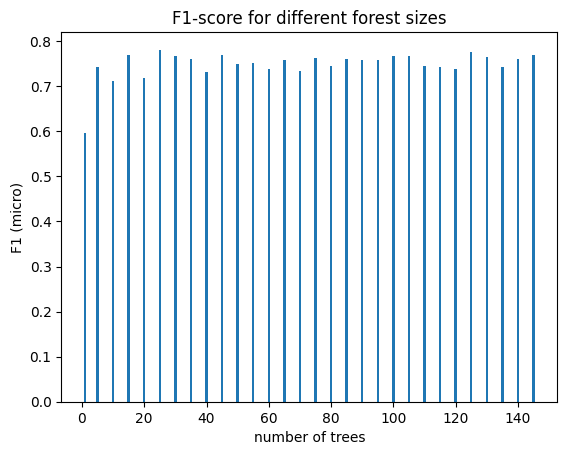

In [11]:
best_forest, _ = evaluate_forrest_of_different_size(dataset=titanic_data)

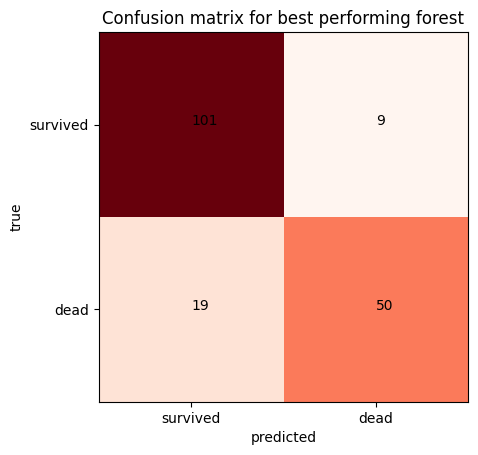

In [12]:
plot_confusion_matrix(dataset=titanic_data, predictor=best_forest)

### Coffee Dataset

Best F1-score 0.75 for number_of_trees = 115.


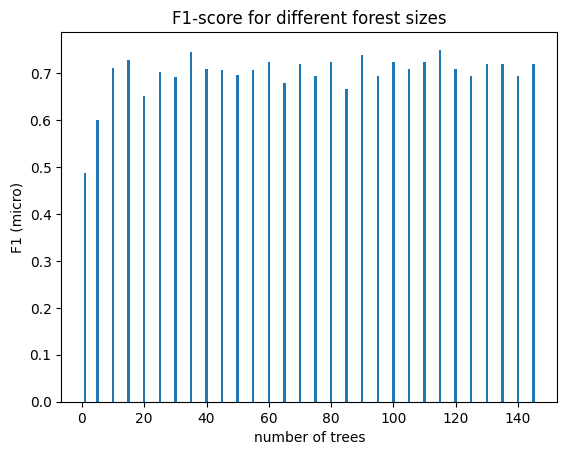

In [13]:
best_forest, _ = evaluate_forrest_of_different_size(dataset=coffee_data)

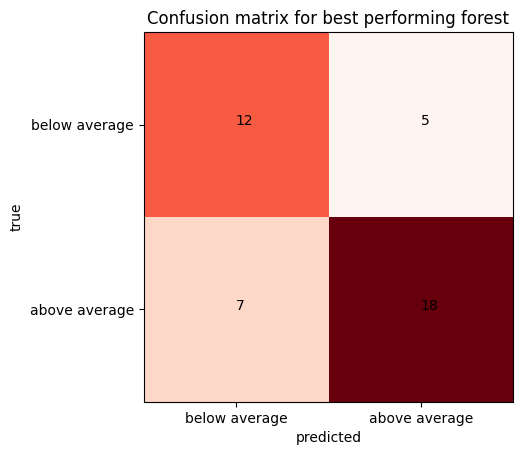

In [14]:
plot_confusion_matrix(dataset=coffee_data, predictor=best_forest)

## Task 2: Interpreting Random Forests (10 Points)

Implement the mean decrease of accuracy for the [sklearn.ensemble.RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) `forest` to analyse learned attribute importances. Use the test set `X_test` and `y_test` as out-of-bag-samples. Permute the values of the assessed attribute by randomly shuffling the corresponding column. Plot the results to compare the importance of each feature. Discuss your results (are any importance values surprising, do the results make sense in the context of the task, ...).

Note: We have already trained the classifier and stored it in the variable `forest`. You only need to implement MDA and the plots for your results.

In [15]:
def create_forest(dataset: BinaryClassificationDataset):
    
    import sklearn.ensemble
    import sklearn.metrics
    forest = sklearn.ensemble.RandomForestClassifier(150)
    forest.fit(dataset.X_train, dataset.y_train)
    prec, rec, f1, _ = sklearn.metrics.precision_recall_fscore_support(dataset.y_test, forest.predict(dataset.X_test), average='micro')
    print('Precision:', prec)
    print('Recall:', rec)
    print('F1-score:', f1)
    return forest

In [16]:
import random

def accuracy(y_true, y_pred):
    return np.sum(y_true == y_pred) / y_true.size


def shuffle(x):
    return np.array(random.sample(list(x), x.size))


def compute_mda(dataset: BinaryClassificationDataset, predictor):
    original_accuracy = accuracy(dataset.y_test, predictor.predict(dataset.X_test))
    repeats = 50
    num_attributes = X_train.shape[1]
    mdas = []
    
    for i in range(num_attributes):
        mda = 0.0
        for _ in range(repeats):
            X_test_perturbed = np.copy(dataset.X_test)
            np.random.shuffle(X_test_perturbed[:, i])  # Shuffle only column i
            perturbed_accuracy = accuracy(dataset.y_test, predictor.predict(X_test_perturbed))
            mda += (original_accuracy - perturbed_accuracy)
        s = mda / repeats
        mdas.append(s)
    
    mda = pd.Series(mdas, index=dataset.feature_names).sort_values(ascending=True)
    fig, ax = plt.subplots()
    ax = mda.plot.barh()
    ax.set_title("Random Forest Feature Importances (MDA)");

### Titantic Dataset

Precision: 0.7877094972067039
Recall: 0.7877094972067039
F1-score: 0.7877094972067039


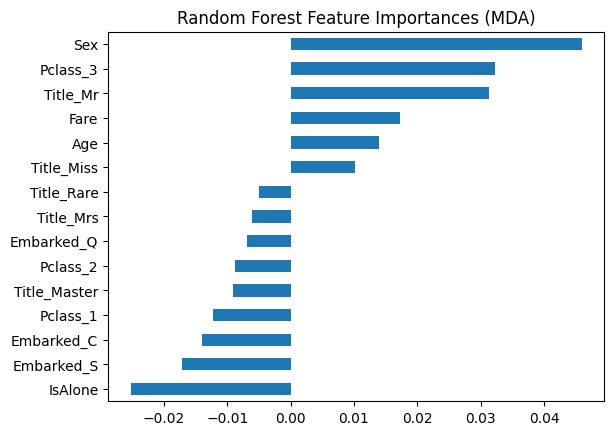

In [17]:
compute_mda(dataset=titanic_data, predictor=create_forest(dataset=titanic_data))

Precision: 0.6904761904761905
Recall: 0.6904761904761905
F1-score: 0.6904761904761905


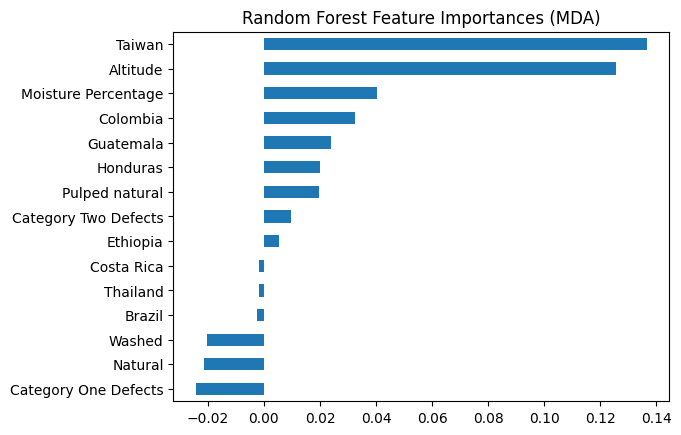

In [18]:
compute_mda(dataset=coffee_data, predictor=create_forest(dataset=coffee_data))

## Task 3: Discrete AdaBoost with Decision Stumps (20 Points) - For all students other than B.Sc. Data Science 

In this task, you will implement the discrete AdaBoost algorithm using decision stumps as weak learners. Your training will run until either `n_learners` weak learners have been added or a perfect accuracy on the training data set is achieved. Use the function `initialize_decision_stumps` to create decision stumps, which you can train on your weighted data using `fit` and predict using `predict`. The decision stumps are instances of the class [sklearn.tree.DecisionTreeClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html).

In addition, you will evaluate your model on the test data (`X_test`, `y_test`) using scikit-learn with the methods shown in the lecture (precision, recall, F1-score, confusion matrices, ...). Feel free to import any functions you need from scikit-learn for this purpose.

In [19]:
def initialize_decision_stump():
    stump = DecisionTreeClassifier(criterion='entropy', max_depth=1)
    return stump


class AdaBoostClassifier(AnyPredictor):
    
    def __init__(self, n_learners):
        self.n_learners = n_learners
        self.learners = []
        self.weights = []
        self.coefficients = []
        self.errors = []
    
    def fit(self, X, y):
        pass
    
    def predict(self, X):
        pass
    

In [20]:
import numpy as np
from sklearn.tree import DecisionTreeClassifier

class AdaBoostClassifier:
    def __init__(self, n_learners=50):
        self.n_learners = n_learners
        self.learners = []
        self.coefficients = []
        self.errors = []

    def fit(self, X, y):
        n_samples = X.shape[0]
        weights = np.ones(n_samples) / n_samples

        for _ in range(self.n_learners):
            stump = DecisionTreeClassifier(max_depth=1, criterion='entropy')
            stump.fit(X, y, sample_weight=weights)
            pred = stump.predict(X)

            # Calculate error and alpha
            misclassified = weights[y != pred]
            error = sum(misclassified)
            if error == 0:  # Prevent division by zero
                continue
            alpha = 0.5 * np.log((1 - error) / error)

            # Store the learner
            self.learners.append(stump)
            self.coefficients.append(alpha)
            self.errors.append(error)

            # Update weights
            weights *= np.exp(-alpha * y * pred)
            weights /= np.sum(weights)  # Normalize to make sum(weights) = 1

    def predict(self, X):
        clf_preds = [clf.predict(X) for clf in self.learners]
        clf_preds = np.array(clf_preds).T  # Transpose to get shape (n_samples, n_learners)

        # Weighted majority vote
        final_pred = np.sign(np.dot(clf_preds, self.coefficients))
        return final_pred

# Example usage
# Assuming you have X_train, X_test, y_train, y_test already defined
adb = AdaBoostClassifier(n_learners=10)
adb.fit(X_train, y_train)
y_pred = adb.predict(X_test)

# Evaluation metrics
from sklearn.metrics import accuracy_score
print("Accuracy:", accuracy_score(y_test, y_pred))


Accuracy: 0.5952380952380952


In [21]:
# Implement your training and evaluation here.
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support

def evaluate_adaboost_for_different_size(dataset: BinaryClassificationDataset, number_of_learners= None):
    
    if number_of_learners is None:
        number_of_learners = list(range(1, 100, 1))
    
    f1scores = []
    best_adaboost = None
    
    for l in number_of_learners:
        adaboost = AdaBoostClassifier(l)
        adaboost.fit(dataset.X_train, dataset.y_train)
        yhat = adaboost.predict(dataset.X_test)
        f1score = precision_recall_fscore_support(dataset.y_test, yhat, average='micro')[2]
        if f1score > max(f1scores + [0.0]):
            best_adaboost = adaboost
        f1scores.append(f1score)
    
    best_adaboost_idx = np.argmax(f1scores)
    best_f1score = f1scores[best_adaboost_idx]
    print(f'Best F1-score {best_f1score:.02f} for number_of_trees = {number_of_learners[best_adaboost_idx]}.')
    
    fig, ax = plt.subplots()
    ax.plot(number_of_learners, f1scores)
    ax.set_xlabel('number of learners')
    ax.set_ylabel('F1 (micro)')
    ax.set_title('F1-score for different numbers of learners')
    
    return best_adaboost


### Titanic

Best F1-score 0.78 for number_of_trees = 1.


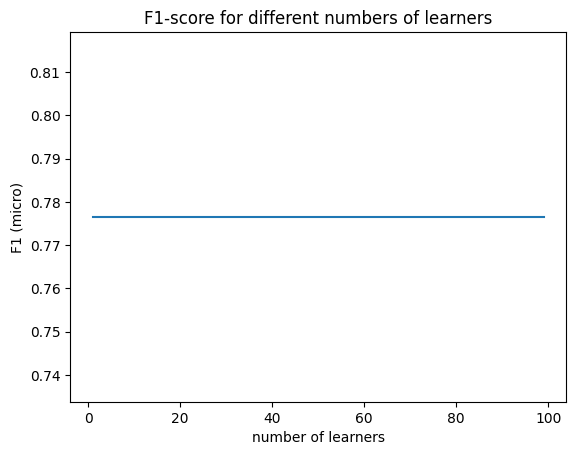

In [22]:
best_adaboost = evaluate_adaboost_for_different_size(titanic_data)

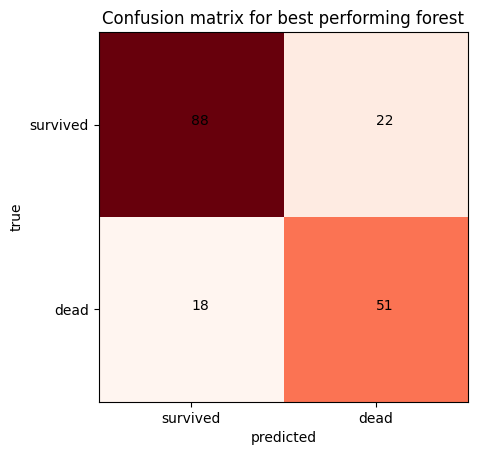

In [23]:
plot_confusion_matrix(dataset=titanic_data, predictor=best_adaboost)

### Coffee

Best F1-score 0.60 for number_of_trees = 1.


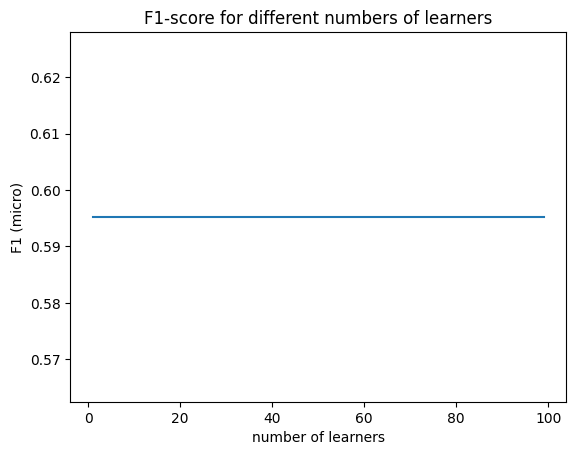

In [24]:
best_adaboost = evaluate_adaboost_for_different_size(coffee_data)

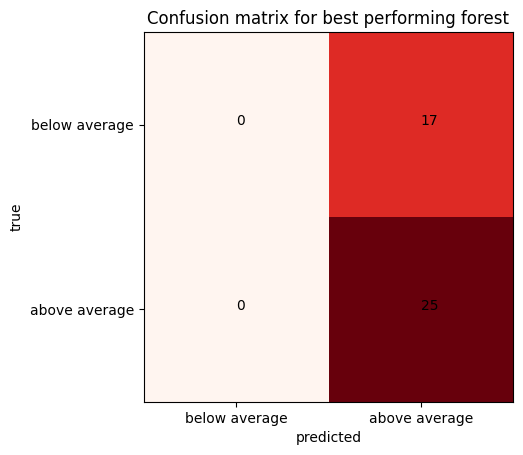

In [25]:
plot_confusion_matrix(dataset=coffee_data, predictor=best_adaboost)